# Lab 6 Reverse Lecture

In this reverse lecture, we'll explore in more details a subset of the functionality of [dask](dask.org), a parallel data processing library for Python. We'll spend the majority of our time on dask's [`DataFrame`](https://docs.dask.org/en/latest/dataframe.html) API, as well as examine concepts such as lazy computation and its relationship with the different schedulers.

We'll follow that by data processing using columnar binary data (Parquet), and end with a brief overview of dask's [`Bag`](https://docs.dask.org/en/latest/bag.html) API, using a JSON data "scraper" as working example.

We close with a list of additional resources for you to learn more about dask, including examples on how to use it for ML tasks. Finally, for the take home portion of this lab, you'll solve two parallel programming assignments, which we detail on the [github repo](http://github.com/mitdbg/datascienceclass/tree/master/lab_6/README.md). 

## Running this notebook

To execute code from a cell, you can either click `Run` at the top, or type `shift+Enter` after clicking a cell.  You can either run the entire notebook (`Restart & Run All` from the `Kernel` drop-down), or run each cell individually.  If you choose the latter, note that it is important that you run cells in order, as later cells depend on earlier ones. And to be able to `Run All` successfully, you'll have to write code for answering some of the questions in the notebook.

Once you open your notebook on the browser, and check that the cells are rendering correctly (e.g., try running the "Python packages" cell below), we're good to go from there.

## Python packages we'll need

First, import the python packages we'll be using for the lab:

In [1]:
import time
from time import perf_counter

# Data processing.
import json
import numpy as np
import pandas as pd

# Q6: For loading multiple CSVs into a single (pandas) dataframe.
import glob
import os

# Plotting.
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set_style('whitegrid')

# "Vanilla" python parallelism.
import multiprocessing

# Scalable data analytics: dask.
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import graphviz

# Unused: scalable data analytics using Spark.
#from pyspark.sql import SparkSession

# For GC large pandas dataframes after use.
import gc

# Ignore warnings.
import warnings
warnings.simplefilter("ignore")

## Part 1: dask

Dask is a python library aimed at parallel computation. It comprises two main components: a task scheduler, and a collection of data structures suited for different parallel programming tasks. Take a look at the [main page of their documentation](https://docs.dask.org/en/latest/) for more details.

In this part of the reverse lecture, we'll introduce you to a subset of these features, as well as cover example tasks using the two different categories of dask schedulers.

Additionally, of special interest to our course is the fact that dask provides an interface that almost exactly matches that of numpy arrays and pandas dataframes. We'll see that this is useful when speeding up some of the data analysis tasks we've covered so far in our course.


### Example pandas vs dask comparison: data loading

Before getting into too many details about the different task schedulers, let's take a look at a simple example runtime comparison between pandas and dask. Specifically, let's load the same spotify dataset from lab 4 in both, and see how long each one takes:

In [3]:
%%time
# load dataset using pandas:
df = pd.read_csv('data/spotify_songs.csv')

CPU times: user 397 ms, sys: 17.4 ms, total: 414 ms
Wall time: 414 ms


In [4]:
%%time
# load dataset using dask:
dd_df = dd.read_csv('data/spotify_songs.csv')

CPU times: user 11.3 ms, sys: 8.26 ms, total: 19.6 ms
Wall time: 18.4 ms


Here we already see a 20x difference, which is impressive. However, this is also because dask does *lazy* computation.  That is, dask arrays have the required shape and data type, but they still point to data on disk. The loading is *lazy* in the sense that dask will load the array contents into memory (and in small chunks) only when necessary.

We can observe this effect in action when we ask dask to compute an operation that requires inspecting the entire contents of the dataset.

**Q1. Inspect the runtime each of the two dataframes (both pandas and dask) using `describe()`. How does the output in pandas compare to that of dask?**

In [5]:
%%time
# Q1: YOUR CODE GOES HERE (pandas)
df.describe()

CPU times: user 90.8 ms, sys: 28.9 ms, total: 120 ms
Wall time: 133 ms


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,228159.000000,228159.000000,228159.000000,2.281590e+05,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000
mean,44.209130,0.351200,0.554198,2.366092e+05,0.580967,0.137310,0.214638,-9.354658,0.122442,117.423062,0.444795
std,17.276599,0.351385,0.183949,1.166787e+05,0.260577,0.292447,0.196977,5.940994,0.186264,30.712458,0.255397
min,0.000000,0.000001,0.056900,1.550900e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,33.000000,0.030900,0.437000,1.862530e+05,0.405000,0.000000,0.097700,-11.287000,0.036800,92.734000,0.232000
50%,47.000000,0.205000,0.570000,2.211730e+05,0.618000,0.000037,0.128000,-7.515000,0.050600,115.347000,0.430000
75%,57.000000,0.689000,0.690000,2.648400e+05,0.793000,0.023400,0.263000,-5.415000,0.109000,138.887000,0.643000
max,100.000000,0.996000,0.987000,5.552917e+06,0.999000,0.999000,1.000000,1.585000,0.967000,239.848000,1.000000


In [6]:
%%time
# Q1: YOUR CODE GOES HERE (dask)
dd_df.describe()            

CPU times: user 99.6 ms, sys: 0 ns, total: 99.6 ms
Wall time: 95.1 ms


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
npartitions=1,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...


**Q2. Clicker question: just by running `describe()` (and nothing else) on both `df` (pandas) and `dd_df` (dask), which of the following is true?**

**a)** both output the same

**b)** pandas output is more informative

**c)** dask output is more informative

So if we want dask to actually perform computations for us, we need to call `compute()`. For example, in the case of `describe()` above:

In [7]:
%%time
dd_df.describe().compute()

CPU times: user 769 ms, sys: 58.9 ms, total: 828 ms
Wall time: 674 ms


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,228159.000000,228159.000000,228159.000000,2.281590e+05,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000
mean,44.209130,0.351200,0.554198,2.366092e+05,0.580967,0.137310,0.214638,-9.354658,0.122442,117.423062,0.444795
std,17.276599,0.351385,0.183949,1.166787e+05,0.260577,0.292447,0.196977,5.940994,0.186264,30.712458,0.255397
min,0.000000,0.000001,0.056900,1.550900e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,33.000000,0.030900,0.437000,1.862530e+05,0.405000,0.000000,0.097700,-11.287000,0.036800,92.734000,0.232000
50%,47.000000,0.205000,0.570000,2.211730e+05,0.618000,0.000037,0.128000,-7.515000,0.050600,115.347000,0.430000
75%,57.000000,0.689000,0.690000,2.648400e+05,0.793000,0.023400,0.263000,-5.415000,0.109000,138.887000,0.643000
max,100.000000,0.996000,0.987000,5.552917e+06,0.999000,0.999000,1.000000,1.585000,0.967000,239.848000,1.000000


We can also inspect the task graph that dask assembles and executes for the computation:

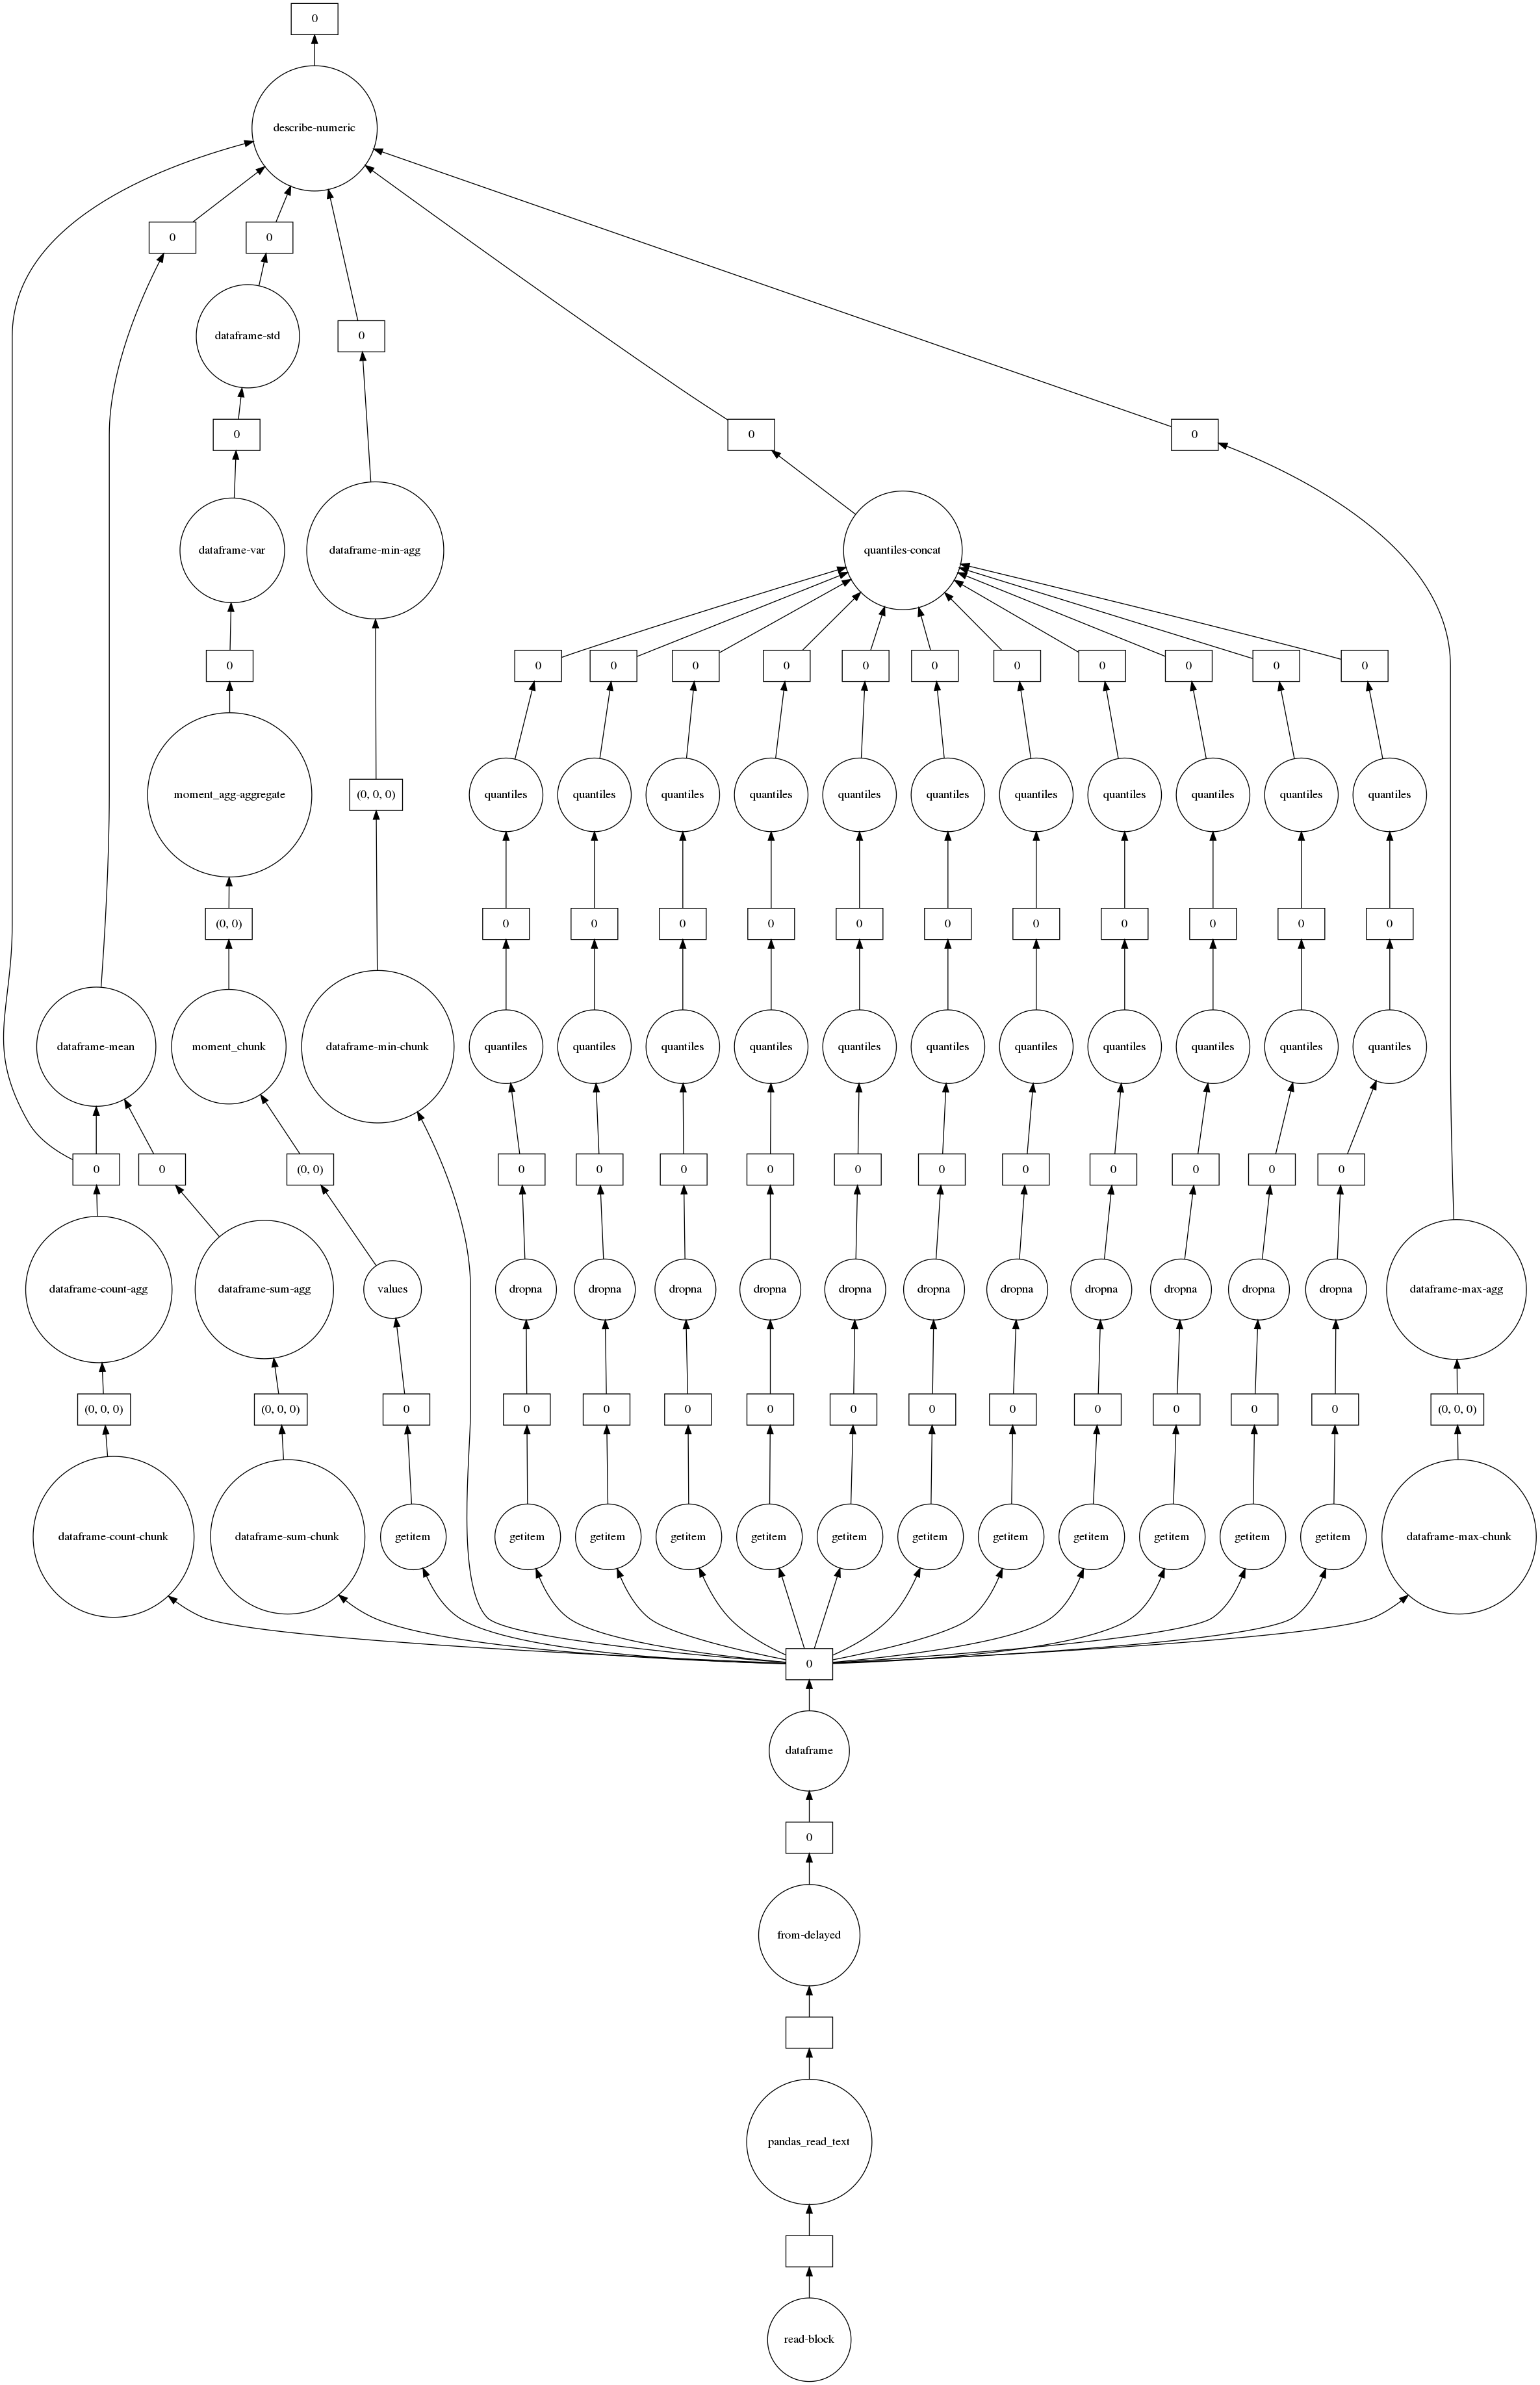

In [8]:
dd_df.describe().visualize()

As we can see above, dask will try and perform as many block computations as possible, only merging and aggregating block results as needed.

**Q3. Clicker question: why do we have 11 "pipelines" in parallel for computing quantiles in the task graph above?**

**a)** This is the number of workers dask is using for the computation.

**b)** This is the number of categorical columns the dataframe has.

**c)** This is the number of numerical columns the dataframe has.

**d)** This is the number of threads dask is using for the computation.

### Task scheduler

Dask provides two categories of task schedulers: *single machine* and *distributed*. From the client setup [documentation](https://docs.dask.org/en/latest/setup.html?highlight=client#setup): 

> **Single machine scheduler:** This scheduler provides basic features on a local process or thread pool. This scheduler was made first and is the default. It is simple and cheap to use. It can only be used on a single machine and does not scale.
>
> **Distributed scheduler:** This scheduler is more sophisticated. It offers more features, but also requires a bit more effort to set up. It can run locally or distributed across a cluster.

If you load data into a dask dataframe, and run some computation on it, when you call `compute()` to start the computation it will use the *single machine scheduler*. For example, the sum over `acousticness` below:

In [9]:
%%time
# sum values for acousticness column using pandas
df.acousticness.sum()

CPU times: user 2.36 ms, sys: 114 µs, total: 2.48 ms
Wall time: 1.67 ms


80129.52932901

In [10]:
%%time
# sum values for acousticness column using dask.
# This computation uses the single machine scheduler:
dd_df.acousticness.sum().compute()

CPU times: user 409 ms, sys: 38.7 ms, total: 448 ms
Wall time: 447 ms


80129.52932901

To use the *distributed scheduler* (even if single node on the same machine), you need to explicitly create a dask [`Client`](https://docs.dask.org/en/latest/setup.html?highlight=client#setup).  Hence, starting a dask `Client` is optional. We'll go through this step, however, as it provides an example of how to setup a [`LocalCluster`](https://distributed.dask.org/en/latest/local-cluster.html). Creating a dask client will also provide a dashboard that we can use to monitor the dask workers while they're computing results for us.

There are several ways to create a dask client that connects to a `LocalCluster`. We'll do each step explicitly, although if you create a `Client` without specifying which cluster to connect to, by default dask will create a task scheduler associated to a `LocalCluster` instance.

First, we check how many cores we have in our server:

In [3]:
n_cores = multiprocessing.cpu_count()
print('number of cores we have: ', n_cores)

number of cores we have:  8


We'll use that to size the number of workers for our `LocalCluster` instance, and create a `Client` connected to it:

In [4]:
# multithreaded:
# cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=4)
# multiprocessing:
# cluster = LocalCluster(n_workers=n_cores, processes=True)

# If we start out the dask-scheduler from CLI on the Docker container using:
# $ dask-scheduler --host 0.0.0.0 --dashboard-address 8787
#
# Then we specify the address for the client explicitly:
# client = Client(address='0.0.0.0:8786')

# If we start out the dask-scheduler from this jupyter notebook, then need
# to set "ip=None" for the status dashboard to work correctly via Docker.
# See:
# https://github.com/dask/distributed/issues/1875#issuecomment-387519880
cluster = LocalCluster(ip=None, n_workers=n_cores, processes=True)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42731 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 67.37 GB


In [13]:
# Info on each worker, together with how many threads per worker.
client.ncores()

# To restart the client and scheduler
#client.restart()
#
# To shutdown the client and scheduler
#client.shutdown()

{'tcp://127.0.0.1:33371': 1,
 'tcp://127.0.0.1:35875': 1,
 'tcp://127.0.0.1:37623': 1,
 'tcp://127.0.0.1:40077': 1,
 'tcp://127.0.0.1:40305': 1,
 'tcp://127.0.0.1:40747': 1,
 'tcp://127.0.0.1:40863': 1,
 'tcp://127.0.0.1:45873': 1}

We can scale the cluster down:

In [14]:
n_workers = n_cores / 2
print('Scale cluster down: ')
cluster.scale(n_workers)

print('\nWait a bit for scaling to take effect...')
time.sleep(1)

print('\nCluster workers:')
client.ncores()

Scale cluster down: 

Wait a bit for scaling to take effect...

Cluster workers:


{'tcp://127.0.0.1:35875': 1,
 'tcp://127.0.0.1:37623': 1,
 'tcp://127.0.0.1:40305': 1,
 'tcp://127.0.0.1:40747': 1}

And scale it back up again:

In [15]:
n_workers = n_cores
print('Scale cluster up again: ')
cluster.scale(n_workers)

print('\nWait a bit for scaling to take effect...')
time.sleep(1)

print('\nCluster workers:')
client.ncores()

Scale cluster up again: 

Wait a bit for scaling to take effect...

Cluster workers:


{'tcp://127.0.0.1:35025': 1,
 'tcp://127.0.0.1:35875': 1,
 'tcp://127.0.0.1:37261': 1,
 'tcp://127.0.0.1:37623': 1,
 'tcp://127.0.0.1:40305': 1,
 'tcp://127.0.0.1:40747': 1,
 'tcp://127.0.0.1:46159': 1,
 'tcp://127.0.0.1:46653': 1}

**Q4. Measure the time to compute the total sum of `acousticness` for `dd_df` on a local cluster with varying number of workers. Start with 1 core, and double number of cores all the way up to 8, or however many cores you have available (if less than 8). Take a look at our usage of `scale()` above for how to scale your cluster up or down, and at [`time.perf_counter`](https://docs.python.org/3/library/time.html#time.perf_counter) to measure elapsed time.** 

**Compare it against the time you get from using pandas. Was dask faster or slower than pandas?**

In [17]:
# Q4: YOUR CODE GOES HERE.
print('Using pandas:')
t1_start = perf_counter()
df.acousticness.sum()
t1_stop = perf_counter()
print('Pandas time (ms): %s' % ((t1_stop - t1_start)*1000))

print('\nUsing dask:')
w=1;
while w <= n_cores:
    print('Resizing cluster to %s worker(s)...' % w)
    time.sleep(1)
    
    t1_start = perf_counter()
    dd_df.acousticness.sum().compute()
    t1_stop = perf_counter()
    
    print('dask time (ms): %s' % ((t1_stop - t1_start)*1000))
    w*=2;

Using pandas:
Pandas time (ms): 4.079422913491726

Using dask:
Resizing cluster to 1 worker(s)...
dask time (ms): 938.2482040673494
Resizing cluster to 2 worker(s)...
dask time (ms): 538.0038842558861
Resizing cluster to 4 worker(s)...
dask time (ms): 461.7013595998287
Resizing cluster to 8 worker(s)...
dask time (ms): 503.92221566289663


As we can see above, the Spotify 218k songs dataset is not large enough to justify the additional scheduler overhead from dask. Specifically, on datasets that comfortably fit within available memory, pandas is expected to be faster than dask for most operations other than loading from disk. Take a look at ["Best Practices"](https://docs.dask.org/en/latest/dataframe-best-practices.html) section of dask documentation for more details.

So let's use a larger dataset instead. We can use dask's `demo` package to create a synthetic timeseries dataset:

In [5]:
# This lazily creates a timeseries dataset for us with around 7.6M rows.
dd_df = dd.demo.make_timeseries(#start='2018-01-01',
                                #end='2018-03-30',
                                # NOTE: Use the smaller dataset (start_time above)
                                # for the take home part. I'll use the earlier start time
                                # below to obtain a larger dataset for demo'ing in class:
                                start='2008-01-01',
                                end='2018-03-30',
                                dtypes={'x': float, 'y': float, 'id': int},
                                freq='1s',
                                partition_freq='24h')

dd_df

,id,x,y
npartitions=3741,,,
2008-01-01,int64,float64,float64
2008-01-02,...,...,...
...,...,...,...
2018-03-29,...,...,...
2018-03-30,...,...,...


As we've learned so far, dask computations are lazy up until we either explicitly call `compute()`, or call computations that themselves call `compute()`.

This is why creating a large dataset above is almost instant. When we call `make_timeseries()`, calculates the number of partitions required for the parallel computation (we asked for one partition every 24h on that date range). It will only perform the actual computation required to create the dataset or brings required data chunks into memory once we actually need it to.

We can see below that dask uses lazy computations even for the shape attribute:

In [19]:
print('pandas shape: ', df.shape)
print('dask shape: ', dd_df.shape)

pandas shape:  (228159, 18)
dask shape:  (Delayed('int-794c7bca-4620-42b8-83fc-d33dec629b24'), 3)


We can retrieve the actual shape by again calling `compute()`, or by calling `len()`, which itself calls `compute()` behind the scenes: 

In [20]:
print('dask shape (compute): ', dd_df.index.compute())
print('dask shape (compute): ', len(dd_df.index))

dask shape (compute):  DatetimeIndex(['2008-01-01 00:00:00', '2008-01-01 00:00:01',
               '2008-01-01 00:00:02', '2008-01-01 00:00:03',
               '2008-01-01 00:00:04', '2008-01-01 00:00:05',
               '2008-01-01 00:00:06', '2008-01-01 00:00:07',
               '2008-01-01 00:00:08', '2008-01-01 00:00:09',
               ...
               '2018-03-29 23:59:50', '2018-03-29 23:59:51',
               '2018-03-29 23:59:52', '2018-03-29 23:59:53',
               '2018-03-29 23:59:54', '2018-03-29 23:59:55',
               '2018-03-29 23:59:56', '2018-03-29 23:59:57',
               '2018-03-29 23:59:58', '2018-03-29 23:59:59'],
              dtype='datetime64[ns]', name='timestamp', length=323222400, freq='S')
dask shape (compute):  323222400


Similarly, computing memory usage for the dataframe, as well as the number of rows in it will both call `compute()` behind the scenes:

In [21]:
dd_df.info(memory_usage='deep')
print('Number of rows: ', len(dd_df))

<class 'dask.dataframe.core.DataFrame'>
Columns: 3 entries, id to y
dtypes: float64(2), int64(1)
memory usage: 9.6 GB
Number of rows:  323222400


**Q5. Compare the runtimes of running `head()` and `len(dd_df.index)` on the dask dataframe. Which one was faster? Why do you think that was the case?**

In [23]:
# Q5: YOUR CODE GOES HERE.
t1_start = perf_counter()
dd_df.head()
t1_stop = perf_counter()
print('dd_df.head() runtime (ms): %s' % ((t1_stop - t1_start)*1000))

t1_start = perf_counter()
len(dd_df.index)
t1_stop = perf_counter()
print('len(dd_df.index) runtime (ms): %s' % ((t1_stop - t1_start)*1000))

dd_df.head() runtime (ms): 52.06026043742895
len(dd_df.index) runtime (ms): 12164.575931616127


Next, let's compare the total runtime of a sequence of operations over the dask and pandas dataframes:

In [24]:
%%time
# Filter and groupby using dask.
dd_df2 = dd_df[dd_df.y > 0]
dd_df3 = dd_df2.groupby('id').x.std()

# Calling head() will also call compute() behind the scenes.
dd_df3.head()

CPU times: user 15.8 s, sys: 1.22 s, total: 17 s
Wall time: 28.4 s


id
873    0.551208
875    0.558243
878    0.585067
879    0.574874
881    0.581479
Name: x, dtype: float64

In [25]:
%%time
# This gives us a pandas dataframe from the dask dataframe.
df = dd_df.compute()

# Filter and groupby using pandas.
df2 = df[df.y > 0]
df3 = df2.groupby('id').x.std()

df3.head()

# Garbage collect the pandas dataframes we created.
#
# XXX: pandas seems to be a lot less memory efficient than dask.
# Even with explicit GC, perf monitors still show leaky behavior.
# https://github.com/pandas-dev/pandas/issues?utf8=%E2%9C%93&q=is%3Aissue+leak+
del df, df2, df3
gc.collect()

CPU times: user 19.5 s, sys: 12.1 s, total: 31.6 s
Wall time: 37.3 s


1022

Operations over the index is where dask usually does a lot better than pandas (see ["Best Practices"](https://docs.dask.org/en/latest/dataframe-best-practices.html)):

In [26]:
%%time
# Dask: rolling standard deviation of 'x' column on 1m windows over the Datetime index.
# Return index of first occurrence of max value out of those rolling 1m stddev.
dd_df.x.rolling('1min').std().loc['2018-01-01':'2018-02-15'].idxmax().compute()

CPU times: user 367 ms, sys: 25.3 ms, total: 393 ms
Wall time: 654 ms


Timestamp('2018-01-30 08:10:18')

In [27]:
%%time
# Dask: rolling standard deviation of 'x' column on 1m windows over the Datetime index.
# Return index of first occurrence of max value out of those rolling 1m stddev.
df = dd_df.compute()
df.x.rolling('1min').std().loc['2018-01-01':'2018-02-15'].idxmax()

# GC pandas df.
del df
gc.collect()

CPU times: user 29.6 s, sys: 19.1 s, total: 48.7 s
Wall time: 54.7 s


75701

## Reading and loading data

Let's take a look at processing data in column-oriented binary format using [`Parquet`](https://en.wikipedia.org/wiki/Apache_Parquet). As we've seen in class, Parquet is an open-source column-oriented data storage format. In addition to allowing us to store our dataframe data in a column-wise fashion, it also supports a number of compression techniques (e.g., dictionary encoding, RLE, and bit packing, as we've seen in class).

In this part of the lab, we'll briefly look at how to store and read data written in Parquet format, and compare it to loading the same dataset from CSV.

First, we can save the larger timeseries dataset as both Parquet and CSV format. We'll do this for a smaller subset of the data, as it takes a really long time to save the entire dataset as CSV.

In [6]:
subset_df = dd_df.loc['2018-01-01':'2018-03-30']

# Measure time for saving as Parquet files.
t1_start = perf_counter()
subset_df.to_parquet('data/parquet/')
t1_stop = perf_counter()
print('to_parquet() (ms): %s' % ((t1_stop - t1_start)*1000))

# Measure time for saving as CSV files.
t1_start = perf_counter()
subset_df.to_csv('data/csv/timeseries-*.csv')
t1_stop = perf_counter()
print('to_csv() (ms): %s' % ((t1_stop - t1_start)*1000))

to_parquet() (ms): 3197.0747020095587
to_csv() (ms): 8394.135868176818


Even though we used dask to write to Parquet, both pandas and dask support writing to / reading from Parquet files. The method interface is the same: [pandas's `read_parquet`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_parquet.html) vs [dask's `read_parquet`](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.read_parquet). You can also specify which Parquet engine to use.  There are some [`performance differences between both`](https://stackoverflow.com/questions/51361356/a-comparison-between-fastparquet-and-pyarrow), but for the time being we'll use the default (if you're using our Docker container, you have both installed and the default is `fastparquet`).

**Q6. Measure the runtime of reading a dataframe from the same Parquet and CSV data we saved above. Compare using both pandas and dask, as well as fetching only column `x` vs the entire dataset.**

**NOTE: When we saved our data as Parquet and CSV, we saved into multiple files (#files = #dask partitions). While dask supports reading multiple CSV files directly into a dask dataframe, pandas doesn't support the same for pandas dataframes. Take a look at [`glob`](https://docs.python.org/3/library/glob.html) for expanding the `timeseries-*.csv` into multiple files and [`pd.concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) to create a single pandas dataframe from multiple CSVs.**

In [8]:
# Q6: YOUR CODE GOES HERE.
# Dask + Parquet
t1_start = perf_counter()
dd_df = dd.read_parquet('data/parquet/').compute()
t1_stop = perf_counter()
print('\ndask + parquet (ms): %s' % ((t1_stop - t1_start)*1000))
t1_start = perf_counter()
dd_df = dd.read_parquet('data/parquet/', usecols=['x'])
t1_stop = perf_counter()
print('dask + parquet, only x column (ms): %s' % ((t1_stop - t1_start)*1000))

# Dask + CSV
t1_start = perf_counter()
dd_df = dd.read_csv('data/csv/timeseries-*.csv').compute()
t1_stop = perf_counter()
print('\ndask + csv (ms): %s' % ((t1_stop - t1_start)*1000))
t1_start = perf_counter()
dd_df = dd.read_csv('data/csv/timeseries-*.csv', usecols=['x'])
t1_stop = perf_counter()
print('dask + csv, only x column (ms): %s' % ((t1_stop - t1_start)*1000))

# Pandas + Parquet 
t1_start = perf_counter()
df = pd.read_parquet('data/parquet/')
t1_stop = perf_counter()
print('\npandas + parquet (ms): %s' % ((t1_stop - t1_start)*1000))
del df
gc.collect()
t1_start = perf_counter()
df = pd.read_parquet('data/parquet/', columns=['x'])
t1_stop = perf_counter()
print('pandas + parquet, only x column (ms): %s' % ((t1_stop - t1_start)*1000))
del df
gc.collect()

# Pandas + CSV (glob)
t1_start = perf_counter()
csv_files = glob.glob(os.path.join('', 'data/csv/timeseries-*.csv'))
df = pd.concat(map(pd.read_csv, csv_files))
t1_stop = perf_counter()
print('\npandas + csv glob (ms): %s' % ((t1_stop - t1_start)*1000))
del df
gc.collect()
t1_start = perf_counter()
csv_files = glob.glob(os.path.join('', 'data/csv/timeseries-*.csv'))
df = pd.concat(map(lambda file: pd.read_csv(file, usecols=['x']), csv_files))
t1_stop = perf_counter()
print('pandas + csv glob, only x column (ms): %s' % ((t1_stop - t1_start)*1000))
del df
gc.collect()

# Pandas + CSV (from dask)
t1_start = perf_counter()
dd_df = dd.read_csv('data/csv/timeseries-*.csv')
df = dd_df.compute()
t1_stop = perf_counter()
print('\npandas + csv from dask (ms): %s' % ((t1_stop - t1_start)*1000))
del df
gc.collect()
t1_start = perf_counter()
dd_df = dd.read_csv('data/csv/timeseries-*.csv', usecols=['x'])
df = dd_df.compute()
t1_stop = perf_counter()
print('pandas + csv from dask, only x column (ms): %s' % ((t1_stop - t1_start)*1000))
del df
gc.collect()


dask + parquet (ms): 906.8008717149496
dask + parquet, only x column (ms): 17.507873475551605

dask + csv (ms): 3244.79110725224
dask + csv, only x column (ms): 167.48347505927086

pandas + parquet (ms): 742.0799490064383
pandas + parquet, only x column (ms): 689.851151779294

pandas + csv glob (ms): 4561.711590737104
pandas + csv glob, only x column (ms): 2017.6803637295961

pandas + csv from dask (ms): 3193.9786560833454
pandas + csv from dask, only x column (ms): 1024.7067175805569


2239

## Dask bag

Next, we'll look at processing JSON data hosted on the web using the dask [`Bag`](https://docs.dask.org/en/latest/bag.html) data structure ([full API](https://docs.dask.org/en/latest/bag-api.html)). 

There is some overlap between what you can do with bags and dataframes, as we'll see below. However, bags are useful when the data you're analyzing is more naturally represented as Python objects (e.g., dicts) than as tabular data (dataframe). That's often the case with JSON data, which has an almost 1:1 mapping with Python dicts.

From the official documentation:

>Dask Bag implements operations like `map`, `filter`, `groupby` and `aggregations` on collections of Python objects. It does this in parallel and in small memory using Python iterators. It is similar to a parallel version of itertools or a Pythonic version of the PySpark RDD.


### Example: using Bag to process JSON data

Below we'll use events JSON data from a web service that runs Jupyter notebooks called [mybinder.org](http://mybinder.org). Every time a user launches a notebook on platforms such as GitHub or GitLab, mybinder publishes an event and stores it in publicly accessible JSON files (one per day).

For example, we can look at the first 5 events published this past Monday by running:

In [33]:
%%time
db.read_text('https://archive.analytics.mybinder.org/events-2019-10-28.jsonl').take(5)

CPU times: user 638 ms, sys: 260 ms, total: 898 ms
Wall time: 2.71 s


('{"timestamp": "2019-10-28T00:00:00+00:00", "schema": "binderhub.jupyter.org/launch", "version": 3, "provider": "GitHub", "spec": "GLAM-Workbench/trove-unpublished/master", "status": "success", "origin": "gke.mybinder.org"}\n',
 '{"timestamp": "2019-10-28T00:00:00+00:00", "schema": "binderhub.jupyter.org/launch", "version": 3, "provider": "GitHub", "spec": "ipython/ipython-in-depth/master", "status": "success", "origin": "gke.mybinder.org"}\n',
 '{"timestamp": "2019-10-28T00:00:00+00:00", "schema": "binderhub.jupyter.org/launch", "version": 3, "provider": "GitHub", "spec": "ericmjl/Network-Analysis-Made-Simple/master", "status": "success", "origin": "gke.mybinder.org"}\n',
 '{"timestamp": "2019-10-28T00:00:00+00:00", "schema": "binderhub.jupyter.org/launch", "version": 3, "provider": "GitHub", "spec": "ipython/ipython-in-depth/master", "status": "success", "origin": "gke.mybinder.org"}\n',
 '{"timestamp": "2019-10-28T00:00:00+00:00", "schema": "binderhub.jupyter.org/launch", "version"

[`mybinder.org`](mybinder.org) also publishes an index containing all other JSON files that they're currently hosting:

In [9]:
# Load index JSON file, inspect its contents.
db.read_text('https://archive.analytics.mybinder.org/index.jsonl').map(json.loads).take(5)

({'name': 'events-2018-11-03.jsonl', 'date': '2018-11-03', 'count': '7057'},
 {'name': 'events-2018-11-04.jsonl', 'date': '2018-11-04', 'count': '7489'},
 {'name': 'events-2018-11-05.jsonl', 'date': '2018-11-05', 'count': '13590'},
 {'name': 'events-2018-11-06.jsonl', 'date': '2018-11-06', 'count': '13920'},
 {'name': 'events-2018-11-07.jsonl', 'date': '2018-11-07', 'count': '12766'})

Using bag's [`pluck`](https://docs.dask.org/en/latest/bag-api.html#dask.bag.Bag.pluck), we can filter out for only the name attributes. We'll use that to retrieve a list of URLs of the index contents:

In [10]:
urls = (db.read_text('https://archive.analytics.mybinder.org/index.jsonl')
                    .map(json.loads)
                    .pluck('name')
                    .compute())
urls = ['https://archive.analytics.mybinder.org/' + u for u in urls]
urls[:3]

['https://archive.analytics.mybinder.org/events-2018-11-03.jsonl',
 'https://archive.analytics.mybinder.org/events-2018-11-04.jsonl',
 'https://archive.analytics.mybinder.org/events-2018-11-05.jsonl']

Using a bag on the list of urls, we can automatically parse the JSON data into Python dict:

In [11]:
notebook_runs = db.read_text(urls).map(json.loads)
notebook_runs.take(2)

({'timestamp': '2018-11-03T00:00:00+00:00',
  'schema': 'binderhub.jupyter.org/launch',
  'version': 1,
  'provider': 'GitHub',
  'spec': 'Qiskit/qiskit-tutorial/master',
  'status': 'success'},
 {'timestamp': '2018-11-03T00:00:00+00:00',
  'schema': 'binderhub.jupyter.org/launch',
  'version': 1,
  'provider': 'GitHub',
  'spec': 'ipython/ipython-in-depth/master',
  'status': 'success'})

**Q7. Using the Python dict data we just saved above in `notebook_runs`, filter it for runs whose provider was "GitHub", and that happened in September 2019. What were the top-3 most run notebooks in that month, and how many times were they run?**

**To answer this question, you have two options. You can either use only `Bag` functions, such as [`filter`](https://docs.dask.org/en/latest/bag-api.html#dask.bag.Bag.filter) and [`frequencies`](https://docs.dask.org/en/latest/bag-api.html#dask.bag.Bag.frequencies) (take a look at some [usage examples here](https://examples.dask.org/bag.html)). Alternatively, you can also use `Bag`'s [`to_dataframe`](https://docs.dask.org/en/latest/bag-api.html#dask.bag.Bag.to_dataframe) and do your processing as dataframe-style computations.**

In [12]:
# Q7: YOUR CODE GOES HERE.
runs = (notebook_runs
          .filter(lambda n: n['provider'] == 'GitHub' and n['timestamp'].startswith('2019-09')))

# Dask bag: top-3.
t1_start = perf_counter()
top_runs = (runs.pluck('spec')
                .frequencies(sort=True)
                .take(3))
t1_stop = perf_counter()
print('Top-3 using dask bag (ms): %s\n' % ((t1_stop - t1_start)*1000))
print('results:')
print(list(top_runs))

# Getting top-3: dask dataframe.
t1_start = perf_counter()
dd_df = notebook_runs.to_dataframe()
dd_df = dd_df[(dd_df['provider'] == 'GitHub') & (dd_df['timestamp'].str.startswith('2019-09'))]
top_runs = (dd_df.spec.value_counts()
                 .nlargest(3)
                 .compute())
t1_stop = perf_counter()
print('\nTop-3 using dask dataframe (ms): %s\n' % ((t1_stop - t1_start)*1000))
print('results:')
print(top_runs)

Top-3 using dask bag (ms): 33639.9002969265

results:
[('ipython/ipython-in-depth/master', 182307), ('jupyterlab/jupyterlab-demo/try.jupyter.org', 103784), ('binder-examples/requirements/master', 22625)]

Top-3 using dask dataframe (ms): 33036.62873804569

results:
ipython/ipython-in-depth/master               182307
jupyterlab/jupyterlab-demo/try.jupyter.org    103784
binder-examples/requirements/master            22625
Name: spec, dtype: int64


# Additional Resources

## Dask examples and tutorials

* Dask examples: https://examples.dask.org/
* Dask for ML tasks (e.g., incremental learning and hyperparameter tuning): https://ml.dask.org/examples.html
* YouTube playlist with introductory Dask concepts: https://www.youtube.com/playlist?list=PLTgRMOcmRb3OlkfAdqJWyGGrQM7eU-mi7

## Dask benchmark codes
* On a 512 core server: https://matthewrocklin.com/blog/work/2017/07/03/scaling
* On GCS: https://gist.github.com/mrocklin/4c198b13e92f881161ef175810c7f6bc#file-scaling-gcs-ipynb
